# Inception v3 Download

In [1]:
%matplotlib inline
import urllib.request
import tarfile
import zipfile
import os
import sys

In [2]:
def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

In [3]:
url = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
filename = url.split('/')[-1]

download_dir = 'model/inception/'
file_path = os.path.join(download_dir, filename)

In [4]:
if not os.path.exists(file_path):
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)
    
    print("Downloading", filename, "...")
    file_path, _ = urllib.request.urlretrieve(url=url,
                                              filename=file_path,
                                              reporthook=download_progress)
    print("Done.")
    
    print("Extracting files.")
    if file_path.endswith(".zip"):
        zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
    elif file_path.endswith((".tar.gz", ".tgz")):
        tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)
    print("Done.")

In [5]:
if os.path.exists(file_path):
    print("Data has apparently already been downloaded and unpacked.")

Data has apparently already been downloaded and unpacked.


# Construct cls_to_name Function

In [6]:
data_dir = 'model/inception'
path_uid_to_cls = "imagenet_2012_challenge_label_map_proto.pbtxt"
path_uid_to_name = "imagenet_synset_to_human_label_map.txt"

In [7]:
uid_to_name = {} 
uid_to_short_name = {}
path = os.path.join(data_dir, path_uid_to_name)

with open(file=path, mode='r') as file:
    lines = file.readlines()
    for line in lines:
        line = line.replace("\n", "")
        elements = line.split("\t")
        uid = elements[0]
        name = elements[1]
        uid_to_name[uid] = name
        
        names = name.split(", ")
        short_name = names[0]
        uid_to_short_name[uid] = short_name

In [8]:
uid_to_cls = {}    
cls_to_uid = {}   
path = os.path.join(data_dir, path_uid_to_cls)
with open(file=path, mode='r') as file:
    lines = file.readlines()
    for line in lines:
        line = line.replace("\n", "")
        if line.startswith("  target_class: "):
            elements = line.split(": ")
            cls = int(elements[1])
        elif line.startswith("  target_class_string: "):
            elements = line.split(": ")
            uid = elements[1]
            uid = uid[1:-1]
            uid_to_cls[uid] = cls
            cls_to_uid[cls] = uid

In [9]:
def cls_to_name(cls):
    uid = cls_to_uid[cls]
    return uid_to_name[uid]

def cls_to_short_name(cls):
    uid = cls_to_uid[cls]
    return uid_to_short_name[uid]

In [10]:
msg = 'Index : {}\nShort Name: {}\nFull Name: {}\n' 
for i in range(10,50,10):
    print(msg.format(i, cls_to_short_name(i), cls_to_name(i)))

Index : 10
Short Name: Persian cat
Full Name: Persian cat

Index : 20
Short Name: whippet
Full Name: whippet

Index : 30
Short Name: jaguar
Full Name: jaguar, panther, Panthera onca, Felis onca

Index : 40
Short Name: black-footed ferret
Full Name: black-footed ferret, ferret, Mustela nigripes



# Restore Graph

In [11]:
import tensorflow as tf
tf.reset_default_graph()

In [12]:
tensor_name_input_jpeg = "DecodeJpeg/contents:0"
tensor_name_input_image = "DecodeJpeg:0"
tensor_name_resized_image = "ResizeBilinear:0"
tensor_name_softmax = "softmax:0"
tensor_name_softmax_logits = "softmax/logits:0"
tensor_name_transfer_layer = "pool_3:0"

In [13]:
graph = tf.Graph()
with graph.as_default():    
    data_dir = "model/inception/"
    path_graph_def = "classify_image_graph_def.pb"
    path = os.path.join(data_dir, path_graph_def)
    with tf.gfile.FastGFile(path, 'rb') as file:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(file.read())
        tf.import_graph_def(graph_def, name='')

Instructions for updating:
Use tf.gfile.GFile.


In [14]:
y_pred = graph.get_tensor_by_name(tensor_name_softmax)
y_logits = graph.get_tensor_by_name(tensor_name_softmax_logits)
resized_image = graph.get_tensor_by_name(tensor_name_resized_image)
transfer_layer = graph.get_tensor_by_name(tensor_name_transfer_layer)
transfer_len = transfer_layer.get_shape()[3]

In [15]:
sess = tf.Session(graph=graph)

In [16]:
def classify(img_path):
    import skimage
    import matplotlib.pyplot as plt
    import numpy as np
    
    img = skimage.io.imread(img_path) 
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
    #feed_dict = {tensor_name_input_image: image}
    image_data = tf.gfile.FastGFile(image_path, 'rb').read()
    feed_dict = {tensor_name_input_jpeg: image_data}
    
    pred = sess.run(y_pred, feed_dict=feed_dict)
    pred = np.squeeze(pred)
    
    idx = pred.argsort()[-5:][::-1]
    for i in range(5):
        msg = '{:>6.2%} : {}'
        prob = pred[idx[i]]
        name = cls_to_name(idx[i])
        print(msg.format(prob, name))    

# Test

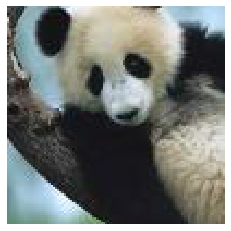

89.11% : giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
 0.78% : indri, indris, Indri indri, Indri brevicaudatus
 0.30% : lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens
 0.15% : custard apple
 0.12% : earthstar


In [17]:
image_path = os.path.join('images', 'cropped_panda.jpg')
# image_path = os.path.join('images', 'parrot.jpg')
# image_path = os.path.join('images', 'parrot_cropped1.jpg')
# image_path = os.path.join('images', 'parrot_cropped2.jpg')
# image_path = os.path.join('images', 'parrot_cropped3.jpg')
# image_path = os.path.join('images', 'parrot_padded.jpg')
# image_path = os.path.join('images', 'elon_musk.jpg')
# image_path = os.path.join('images', 'willy_wonka_new.jpg')
# image_path = os.path.join('images', 'willy_wonka_old.jpg')
# image_path = os.path.join('images', 'test_image.png')
classify(image_path)

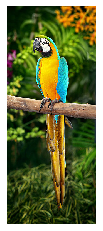

97.18% : macaw
 0.07% : African grey, African gray, Psittacus erithacus
 0.06% : toucan
 0.05% : jacamar
 0.04% : bee eater


In [18]:
# image_path = os.path.join('images', 'cropped_panda.jpg')
image_path = os.path.join('images', 'parrot.jpg')
# image_path = os.path.join('images', 'parrot_cropped1.jpg')
# image_path = os.path.join('images', 'parrot_cropped2.jpg')
# image_path = os.path.join('images', 'parrot_cropped3.jpg')
# image_path = os.path.join('images', 'parrot_padded.jpg')
# image_path = os.path.join('images', 'elon_musk.jpg')
# image_path = os.path.join('images', 'willy_wonka_new.jpg')
# image_path = os.path.join('images', 'willy_wonka_old.jpg')
# image_path = os.path.join('images', 'test_image.png')
classify(image_path)

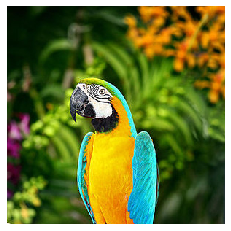

97.52% : macaw
 0.09% : African grey, African gray, Psittacus erithacus
 0.03% : sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita
 0.02% : toucan
 0.02% : reflex camera


In [19]:
# image_path = os.path.join('images', 'cropped_panda.jpg')
# image_path = os.path.join('images', 'parrot.jpg')
image_path = os.path.join('images', 'parrot_cropped1.jpg')
# image_path = os.path.join('images', 'parrot_cropped2.jpg')
# image_path = os.path.join('images', 'parrot_cropped3.jpg')
# image_path = os.path.join('images', 'parrot_padded.jpg')
# image_path = os.path.join('images', 'elon_musk.jpg')
# image_path = os.path.join('images', 'willy_wonka_new.jpg')
# image_path = os.path.join('images', 'willy_wonka_old.jpg')
# image_path = os.path.join('images', 'test_image.png')
classify(image_path)

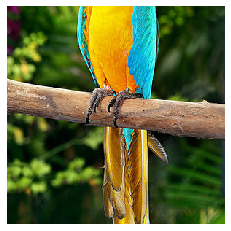

94.21% : macaw
 0.76% : toucan
 0.58% : African grey, African gray, Psittacus erithacus
 0.11% : jacamar
 0.10% : sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita


In [20]:
# image_path = os.path.join('images', 'cropped_panda.jpg')
# image_path = os.path.join('images', 'parrot.jpg')
# image_path = os.path.join('images', 'parrot_cropped1.jpg')
image_path = os.path.join('images', 'parrot_cropped2.jpg')
# image_path = os.path.join('images', 'parrot_cropped3.jpg')
# image_path = os.path.join('images', 'parrot_padded.jpg')
# image_path = os.path.join('images', 'elon_musk.jpg')
# image_path = os.path.join('images', 'willy_wonka_new.jpg')
# image_path = os.path.join('images', 'willy_wonka_old.jpg')
# image_path = os.path.join('images', 'test_image.png')
classify(image_path)

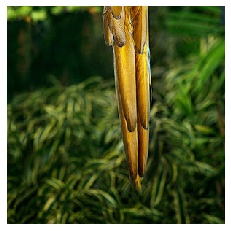

26.51% : jacamar
10.56% : grasshopper, hopper
 3.58% : chime, bell, gong
 2.15% : bulbul
 1.93% : fountain pen


In [21]:
# image_path = os.path.join('images', 'cropped_panda.jpg')
# image_path = os.path.join('images', 'parrot.jpg')
# image_path = os.path.join('images', 'parrot_cropped1.jpg')
# image_path = os.path.join('images', 'parrot_cropped2.jpg')
image_path = os.path.join('images', 'parrot_cropped3.jpg')
# image_path = os.path.join('images', 'parrot_padded.jpg')
# image_path = os.path.join('images', 'elon_musk.jpg')
# image_path = os.path.join('images', 'willy_wonka_new.jpg')
# image_path = os.path.join('images', 'willy_wonka_old.jpg')
# image_path = os.path.join('images', 'test_image.png')
classify(image_path)

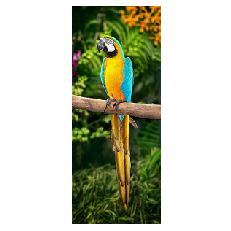

96.87% : macaw
 0.06% : African grey, African gray, Psittacus erithacus
 0.06% : toucan
 0.05% : bee eater
 0.04% : sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita


In [22]:
# image_path = os.path.join('images', 'cropped_panda.jpg')
# image_path = os.path.join('images', 'parrot.jpg')
# image_path = os.path.join('images', 'parrot_cropped1.jpg')
# image_path = os.path.join('images', 'parrot_cropped2.jpg')
# image_path = os.path.join('images', 'parrot_cropped3.jpg')
image_path = os.path.join('images', 'parrot_padded.jpg')
# image_path = os.path.join('images', 'elon_musk.jpg')
# image_path = os.path.join('images', 'willy_wonka_new.jpg')
# image_path = os.path.join('images', 'willy_wonka_old.jpg')
# image_path = os.path.join('images', 'test_image.png')
classify(image_path)

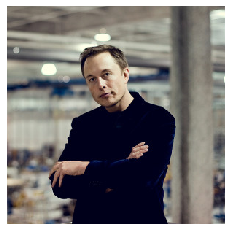

16.63% : sweatshirt
16.45% : abaya
 4.62% : suit, suit of clothes
 3.40% : ping-pong ball
 2.89% : trench coat


In [23]:
# image_path = os.path.join('images', 'cropped_panda.jpg')
# image_path = os.path.join('images', 'parrot.jpg')
# image_path = os.path.join('images', 'parrot_cropped1.jpg')
# image_path = os.path.join('images', 'parrot_cropped2.jpg')
# image_path = os.path.join('images', 'parrot_cropped3.jpg')
# image_path = os.path.join('images', 'parrot_padded.jpg')
image_path = os.path.join('images', 'elon_musk.jpg')
# image_path = os.path.join('images', 'willy_wonka_new.jpg')
# image_path = os.path.join('images', 'willy_wonka_old.jpg')
# image_path = os.path.join('images', 'test_image.png')
classify(image_path)

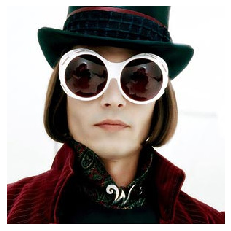

34.47% : sunglasses, dark glasses, shades
18.10% : sunglass
 1.29% : velvet
 0.95% : wig
 0.85% : cowboy hat, ten-gallon hat


In [24]:
# image_path = os.path.join('images', 'cropped_panda.jpg')
# image_path = os.path.join('images', 'parrot.jpg')
# image_path = os.path.join('images', 'parrot_cropped1.jpg')
# image_path = os.path.join('images', 'parrot_cropped2.jpg')
# image_path = os.path.join('images', 'parrot_cropped3.jpg')
# image_path = os.path.join('images', 'parrot_padded.jpg')
# image_path = os.path.join('images', 'elon_musk.jpg')
image_path = os.path.join('images', 'willy_wonka_new.jpg')
# image_path = os.path.join('images', 'willy_wonka_old.jpg')
# image_path = os.path.join('images', 'test_image.png')
classify(image_path)

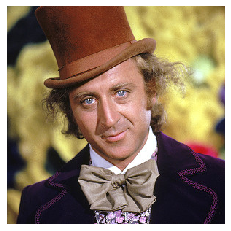

97.98% : bow tie, bow-tie, bowtie
 0.63% : cowboy hat, ten-gallon hat
 0.14% : sombrero
 0.07% : suit, suit of clothes
 0.05% : bolo tie, bolo, bola tie, bola


In [25]:
# image_path = os.path.join('images', 'cropped_panda.jpg')
# image_path = os.path.join('images', 'parrot.jpg')
# image_path = os.path.join('images', 'parrot_cropped1.jpg')
# image_path = os.path.join('images', 'parrot_cropped2.jpg')
# image_path = os.path.join('images', 'parrot_cropped3.jpg')
# image_path = os.path.join('images', 'parrot_padded.jpg')
# image_path = os.path.join('images', 'elon_musk.jpg')
# image_path = os.path.join('images', 'willy_wonka_new.jpg')
image_path = os.path.join('images', 'willy_wonka_old.jpg')
# image_path = os.path.join('images', 'test_image.png')
classify(image_path)

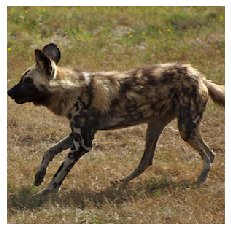

91.80% : African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus
 4.09% : hyena, hyaena
 0.26% : dhole, Cuon alpinus
 0.04% : steel drum
 0.03% : ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin


In [26]:
# image_path = os.path.join('images', 'cropped_panda.jpg')
# image_path = os.path.join('images', 'parrot.jpg')
# image_path = os.path.join('images', 'parrot_cropped1.jpg')
# image_path = os.path.join('images', 'parrot_cropped2.jpg')
# image_path = os.path.join('images', 'parrot_cropped3.jpg')
# image_path = os.path.join('images', 'parrot_padded.jpg')
# image_path = os.path.join('images', 'elon_musk.jpg')
# image_path = os.path.join('images', 'willy_wonka_new.jpg')
# image_path = os.path.join('images', 'willy_wonka_old.jpg')
image_path = os.path.join('images', 'test_image.png')
classify(image_path)

# What happens if img size is not (299, 299, 3)

In [27]:
def get_resized_image(image_path):
    #feed_dict = {tensor_name_input_image: image}
    image_data = tf.gfile.FastGFile(image_path, 'rb').read()
    feed_dict = {tensor_name_input_jpeg: image_data}

    image = sess.run(resized_image, feed_dict=feed_dict)
    image = image.squeeze(axis=0)
    image = image.astype(float) / 255.0
    return image

In [28]:
def plot_resized_image(image_path):
    import matplotlib.pyplot as plt
    resized_image = get_resized_image(image_path)
    plt.imshow(resized_image, interpolation='nearest')
    plt.axis("off")
    plt.show()

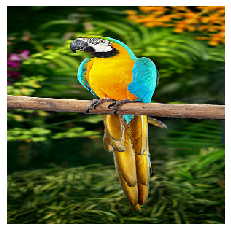

In [29]:
plot_resized_image(image_path="images/parrot.jpg")